In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.initializers import Constant
import keras.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import warnings
import string
import re
warnings.filterwarnings('ignore')
sns.set()
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glovetwitter27b/glove.twitter.27B.200d.txt
/kaggle/input/glovetwitter27b/glove.twitter.27B.25d.txt
/kaggle/input/glovetwitter27b/glove.twitter.27B.50d.txt
/kaggle/input/glovetwitter27b/glove.twitter.27B.100d.txt


## Introduction
This project is an attempt to distinguish tweets that are indicating a disaster is ocurring from tweets that are hyperbolic, sarcastic, satirical, or otherwise not indicative of a real life disaster, such as a forest fire or active shooter. The intent and hope behind machine learning techniques in this realm is to be able to extend the amount of information first responders have access to through using tweets to augment other sources. Twitter users are able to give firsthand accounts of disasters including time, place, and nature of the disaster. This notebook must be able to convert human language to vector form information and find latent features for determining the intent behind a tweet. The total training data includes 38,065 tweets including the text, location, a keyword, and the class label.

In [2]:
#Importing Data
train_raw = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_raw = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print(train_raw.head())
print(test_raw.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [3]:
np.size(train_raw), np.size(test_raw)

(38065, 13052)

In [4]:
np.size(pd.concat([train_raw, test_raw], axis=0))

54380

## Exploratory Data Analysis
A relative few of these tweets actually have a location or keyword attached to them. The test tweets count 13,052 tweets and lack the class label column, but retain the other features. The test data is skewed slightly towards negative labels. We do see duplicate tweets used, and some of which are actually labelled differently from eachother. To handle these problems we will be dropping all columns other than the text of the tweet and label. Additionally we will manually change labels of duplicates to match the most common label for that given tweet. A word cloud for each label was generated to see the kinds of words to expect for a tweet given a label. Words like 'fire', 'derailment', and 'wreckage' appear often in disastrous tweets while words like 'body', 'deluge', and 'siren' are often in non-disastrous tweets. Another aspect of the data cleaning was preventing stop words, punctuation, and capitalization from impacting our analysis. To fix this we removed each of these things from our tweets.

In [5]:
train_raw.isnull().sum(), test_raw.isnull().sum()

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 id             0
 keyword       26
 location    1105
 text           0
 dtype: int64)

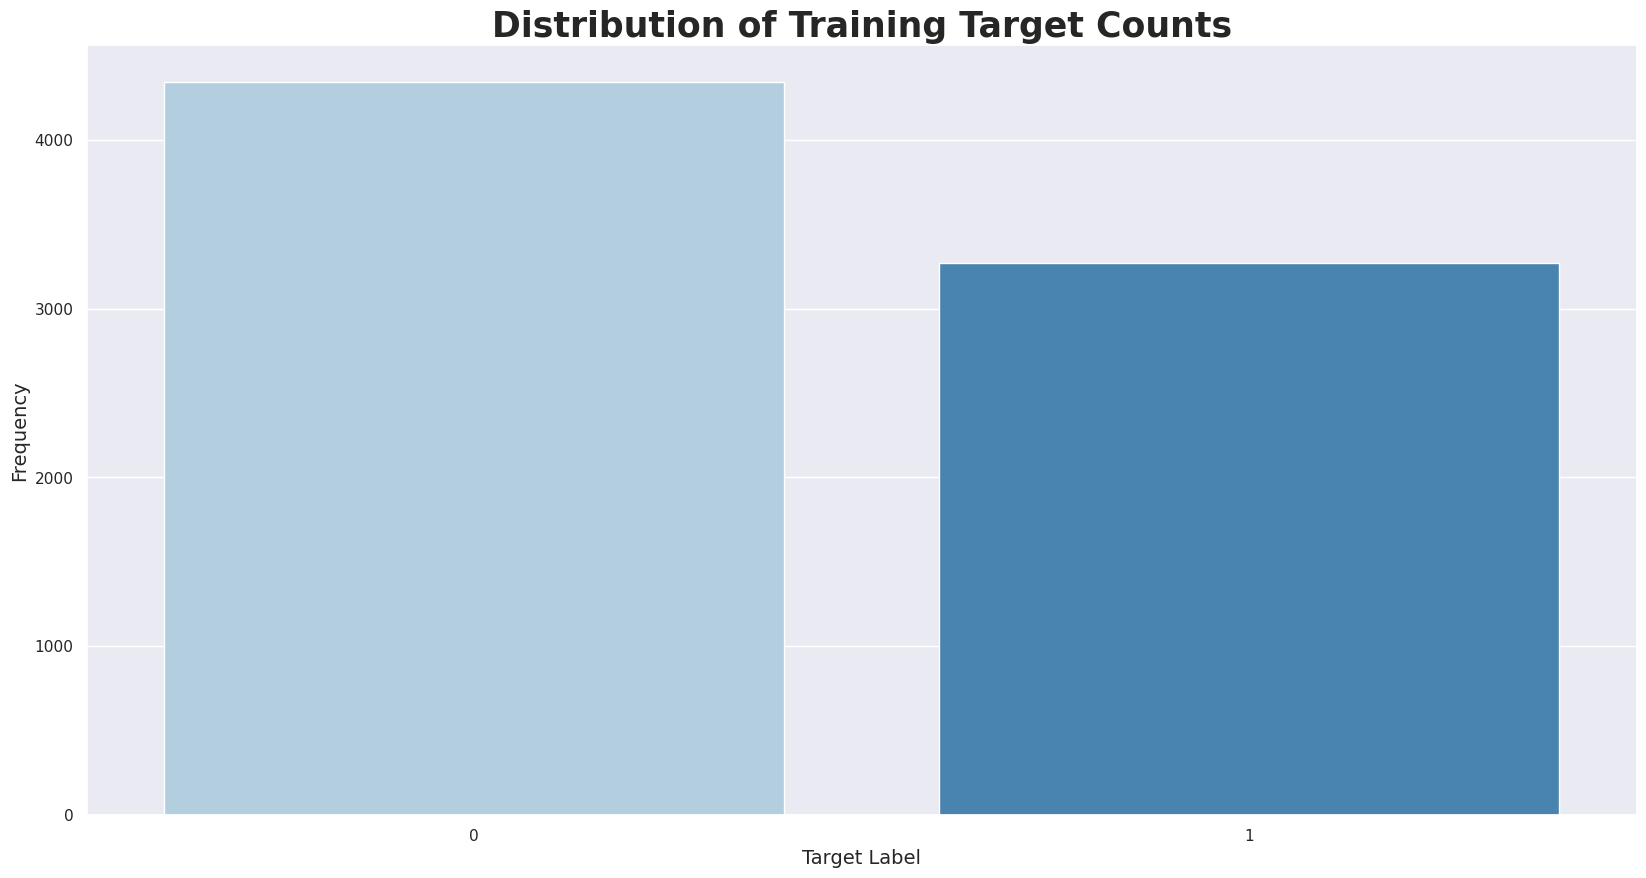

In [6]:
plt.figure(figsize=(20,10))
sns.countplot(x=train_raw.target, palette='Blues')
plt.title("Distribution of Training Target Counts", size=25, weight='bold')
plt.xlabel("Target Label", size=14)
plt.ylabel("Frequency", size=14)
plt.show()

In [7]:
duplicate_values = train_raw[train_raw.text.duplicated()][['text','target']]
duplicate_values.sort_values(by='text')

,text,target
4299,#Allah describes piling up #wealth thinking it...,0
4312,#Allah describes piling up #wealth thinking it...,1
6366,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6373,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
6392,#Bestnaijamade: 16yr old PKK suicide bomber wh...,1
...,...,...
3461,that exploded &amp; brought about the\nbeginni...,0
6103,that horrible sinking feeling when youÛªve be...,0
6094,that horrible sinking feeling when youÛªve be...,0
6123,that horrible sinking feeling when youÛªve be...,1


In [8]:
same_tweet_diff_target_idxs = []
for idx, target in enumerate(duplicate_values.groupby(['text']).agg(list).target):
    if len(list(set(target)))>1:
        same_tweet_diff_target_idxs.append(idx)
duplicate_values.groupby('text').agg(list).iloc[same_tweet_diff_target_idxs]

,target
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,"[0, 1]"
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,"[1, 0]"
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,"[1, 0, 1]"
CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,"[1, 0]"
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,"[1, 1, 0, 0, 0]"
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,"[1, 0]"
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',"[0, 1, 0, 0, 1]"
To fight bioterrorism sir.,"[0, 1, 0]"
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,"[0, 0, 1]"


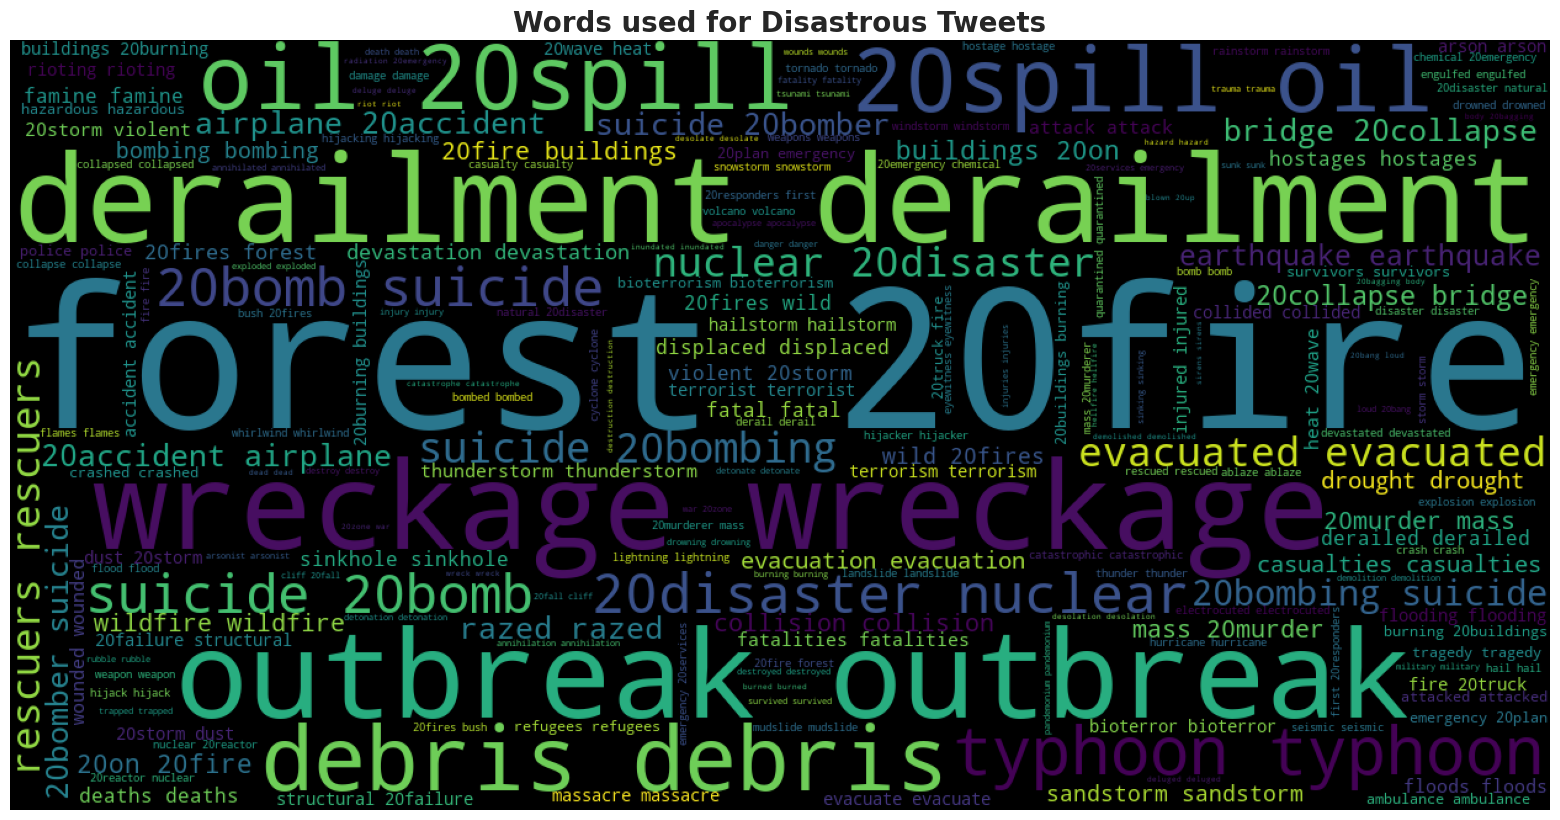

In [9]:
all_keywords = " ".join(keyword for keyword in train_raw[train_raw.target==1].keyword.dropna())
word_cloud= WordCloud(width=1250, height=625, max_font_size=350).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for Disastrous Tweets", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

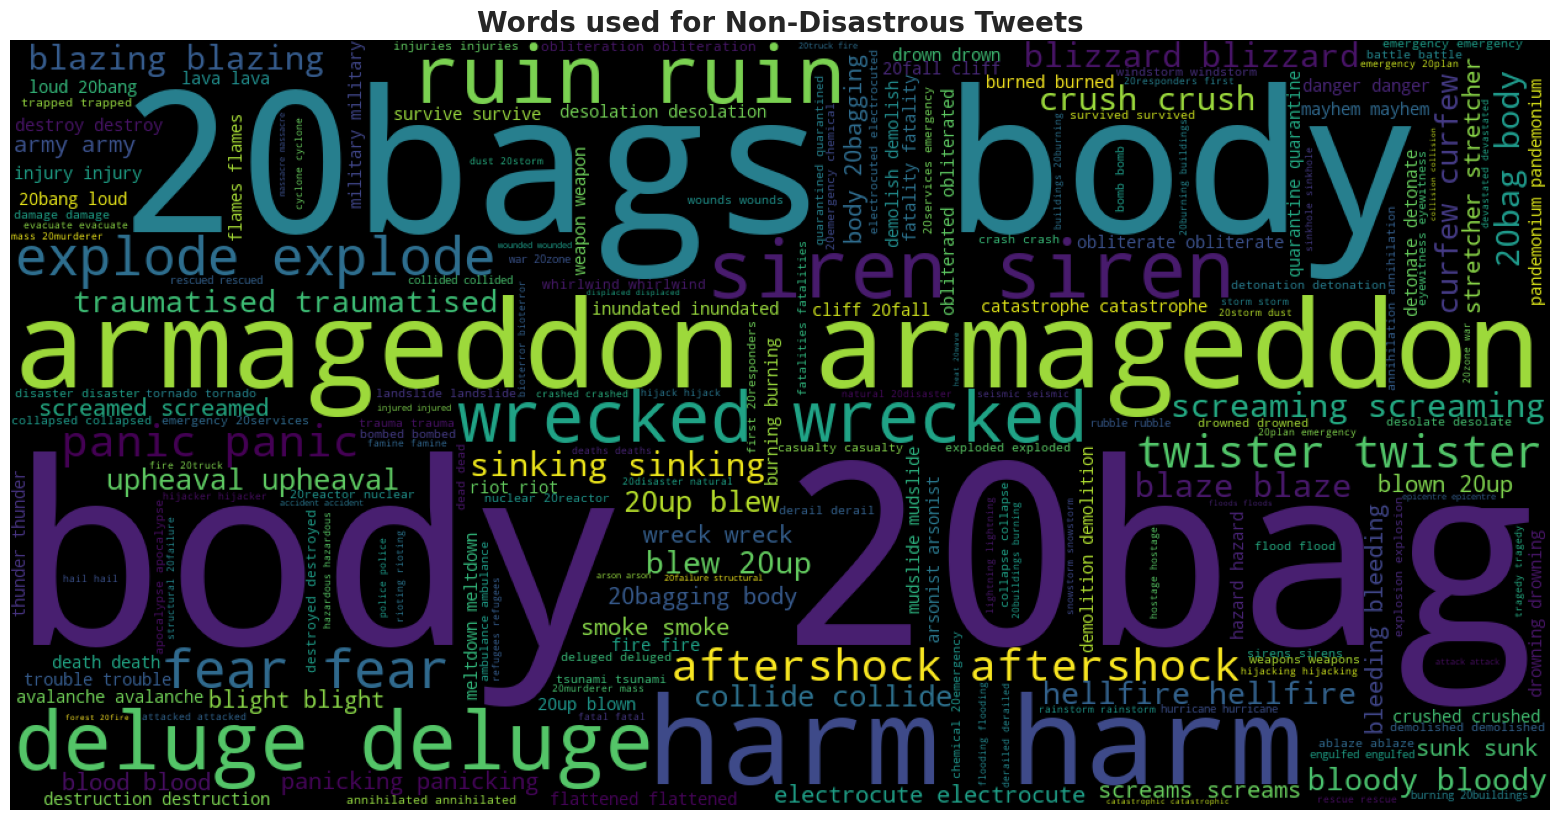

In [10]:
all_keywords = " ".join(keyword for keyword in train_raw[train_raw.target==0].keyword.dropna())
word_cloud= WordCloud(width=1250, height=625, max_font_size=350).generate(all_keywords)
plt.figure(figsize=(20, 10))
plt.title("Words used for Non-Disastrous Tweets", size=20, weight="bold")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [11]:
def clean_text(tweet):
    tweet = tweet.lower() #text to lowercase
    tweet = re.sub(r'\$\w*', '', str(tweet)) #remove stock market symbols
    tweet = re.sub(r'^RT[\s]+', '', str(tweet)) #remove RT or Retweet symbols
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet)) #remove links
    tweet = re.sub(r'#', '', str(tweet)) #remove # or Hashtag symbols
    return tweet

def clean_punctuation(tweet):
    tweet = "".join(word for word in tweet if word not in set(string.punctuation))
    return tweet

def clean_stopwords(tweet):
    STOPWORDS = set(stopwords.words("english"))
    tweet = " ".join(word for word in tweet.split() if word not in STOPWORDS)
    return tweet

def clean_tweet(tweet):
    tweet = clean_text(tweet)
    tweet = clean_punctuation(tweet)
    tweet = clean_stopwords(tweet)
    return tweet

def manual_label_target(df):
    df.loc[df["text"]==
           "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect",
           "target"]= 0
    df.loc[df["text"]==
          "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption",
          "target"] = 0
    df.loc[df["text"]==
          ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4",
          "target"] = 0
    df.loc[df["text"]==
          "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring",
          "target"] = 1
    df.loc[df["text"]==
          "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam",
          "target"] = 0
    df.loc[df["text"]==
          "Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife",
          "target"] = 0
    df.loc[df["text"]==
          "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
          "target"] = 0
    df.loc[df["text"]=="To fight bioterrorism sir.", "target"] = 0
    df.loc[df["text"]==
          "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time",
          "target"] = 0
    return df

In [12]:
train = manual_label_target(train_raw)

train['clean_tweet'] = train.text.apply(clean_tweet)
test = test_raw
test['clean_tweet'] = test_raw.text.apply(clean_tweet)

In [13]:
test.head(), train.head()

(   id keyword location                                               text  \
 0   0     NaN      NaN                 Just happened a terrible car crash   
 1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
 2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
 3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires   
 4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan   
 
                                          clean_tweet  
 0                        happened terrible car crash  
 1  heard earthquake different cities stay safe ev...  
 2  forest fire spot pond geese fleeing across str...  
 3              apocalypse lighting spokane wildfires  
 4             typhoon soudelor kills 28 china taiwan  ,
    id keyword location                                               text  \
 0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
 1   4     NaN      NaN             F

In [14]:
train.drop(['id', 'keyword', 'location', 'text'], axis=1, inplace=True)
test.drop(['id', 'keyword', 'location', 'text'], axis=1, inplace=True)

In [15]:
train.shape, train.head(), test.shape, test.head()

((7613, 2),
    target                                        clean_tweet
 0       1       deeds reason earthquake may allah forgive us
 1       1              forest fire near la ronge sask canada
 2       1  residents asked shelter place notified officer...
 3       1  13000 people receive wildfires evacuation orde...
 4       1  got sent photo ruby alaska smoke wildfires pou...,
 (3263, 1),
                                          clean_tweet
 0                        happened terrible car crash
 1  heard earthquake different cities stay safe ev...
 2  forest fire spot pond geese fleeing across str...
 3              apocalypse lighting spokane wildfires
 4             typhoon soudelor kills 28 china taiwan)

## Model Architecture Part 1
Here we use GloVe embedding to convert words to matrix form. GloVe has pretrained word associations so that words are considered similar based on context. This embedding will be the first layer used in our model, followed by a long short-term memory layer and a dense ReLu layer. We use binary cross entropy, as this is a binary classification, as our loss function, with accuracy as our training metric.

In [16]:
#Here we begin tokenizing all of the words across the tweets. First we have to add each word to a vector as their own entry.
all_tweets_as_words = []
for text in train['clean_tweet']:
    all_tweets_as_words.append([word.lower() for word in word_tokenize(text)])
print(all_tweets_as_words[2031])
print(len(all_tweets_as_words))
#test = temptest

['last', 'tree', 'cut', 'last', 'fish', 'eaten', 'last', 'stream', 'poisoned', 'realize']
7613


In [17]:
#Splitting the train data into a training set and evaluation set. 80% of the data will be trained on and 20% will be evaluated on.
X = train['clean_tweet']
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=195)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6090,) (6090,)
(1523,) (1523,)


In [18]:
#Here we fit a tokenizer on the training set. We convert the text into sequences
tokenizer = Tokenizer(len(all_tweets_as_words))
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
print("First Tweet as Integer Sequences: " + str(X_train[0]))
X_train = pad_sequences(X_train, maxlen=32, padding="post", truncating="post")
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=32, padding="post", truncating="post")
#print(X_train)

test = tokenizer.texts_to_sequences(test['clean_tweet'])
test = pad_sequences(test, maxlen=32, padding='post', truncating='post')
#print(test)

First Tweet as Integer Sequences: [5435, 5436, 5437, 5438, 5439, 164, 2694, 230, 5440, 2695, 5441, 621]


In [19]:
#A quick look at the word_index, a dictionary that assigns words to integers
import itertools
dict(itertools.islice(tokenizer.word_index.items(), 5))

{'like': 1, 'im': 2, 'amp': 3, 'fire': 4, 'get': 5}

In [20]:
#Here we use GloVe embedding to essentially describe words based on their context. Synonyms and hypernyms are considered closer to one another and this file was made using twitter data.
#We read this in to be used in our embedding layer to convert all of our words into 100 latent vectors
#The dictionary here is a read in version of the file, with words assigned to arrays used in calculating similarities between words
embedding = {}
with open("/kaggle/input/glovetwitter27b/glove.twitter.27B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

In [21]:
#Here we create a matrix that includes the embedding vectors from above that correspond to words in our training set
embedding_matrix = np.zeros((len(all_tweets_as_words)+1, 100))
for i, word in tokenizer.index_word.items():
    if i < (len(all_tweets_as_words)+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6090, 32) (6090,)
(1523, 32) (1523,)


## Model Architecture Part 2
The first model is a sequential model with the first hidden layer an embedding layer, converting the vectors from above into 100, non-trainable latent vectors. We then add a long short-term memory layer with an input size of 100 and a dropout rate of 0.1. Finally we output a dense layer to 1 value, using the ReLu activation function. We use binary cross entropy as a loss function, adam, a version of an SGD optimizer, as our optimizer, and test for accuracy. For hyperparameter tuning we keep the epoch count at 8 but the batch size is halved for the second attempt and doubled for the third.

The second model is very similar but includes another dense layer. This will increase computation times and the number of trainable parameters, but hopefully increase accuracy. The hyperparameter tuning occurs identically here.

In [32]:
def assign_model():
    model = Sequential()

    model.add(Embedding(input_dim=len(all_tweets_as_words)+1, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=32, trainable=False))
    model.add(LSTM(100, dropout=0.1))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    #model.summary()

In [33]:
def assign_model2():
    model2 = Sequential()

    model2.add(Embedding(input_dim=len(all_tweets_as_words)+1, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=32, trainable=False))
    model2.add(LSTM(100, dropout=0.1))
    model2.add(Dense(100, activation='relu'))
    model2.add(Dense(1, activation='relu'))

    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model2
    #model2.summary()

In [34]:
#plotting the training and accuracy of the model across epochs
def plot_metrics(model, size):
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    sns.lineplot(x=[*range(1, 9)],y=model.history['loss'],ax=ax[0],label='train loss')
    sns.lineplot(x=[*range(1, 9)],y=model.history['val_loss'],ax=ax[0],label='test loss')
    sns.lineplot(x=[*range(1, 9)],y=model.history['accuracy'],ax=ax[1],label='train accuracy')
    sns.lineplot(x=[*range(1, 9)],y=model.history['val_accuracy'],ax=ax[1],label='test accuracy')
    fig.suptitle("Batch Size: " + str(size))

Batch Count = 256
Epoch 1/8
24/24 [==============================] - 6s 130ms/step - loss: 1.0745 - accuracy: 0.6087 - val_loss: 0.6011 - val_accuracy: 0.6500
Epoch 2/8
24/24 [==============================] - 2s 101ms/step - loss: 0.5587 - accuracy: 0.7402 - val_loss: 0.4759 - val_accuracy: 0.7833
Epoch 3/8
24/24 [==============================] - 2s 103ms/step - loss: 0.5029 - accuracy: 0.7782 - val_loss: 0.4658 - val_accuracy: 0.7873
Epoch 4/8
24/24 [==============================] - 3s 105ms/step - loss: 0.4776 - accuracy: 0.7857 - val_loss: 0.4444 - val_accuracy: 0.8017
Epoch 5/8
24/24 [==============================] - 2s 103ms/step - loss: 0.4808 - accuracy: 0.7846 - val_loss: 0.4354 - val_accuracy: 0.7978
Epoch 6/8
24/24 [==============================] - 2s 104ms/step - loss: 0.4748 - accuracy: 0.7897 - val_loss: 0.4448 - val_accuracy: 0.8070
Epoch 7/8
24/24 [==============================] - 3s 111ms/step - loss: 0.4871 - accuracy: 0.7964 - val_loss: 0.4672 - val_accuracy: 0.

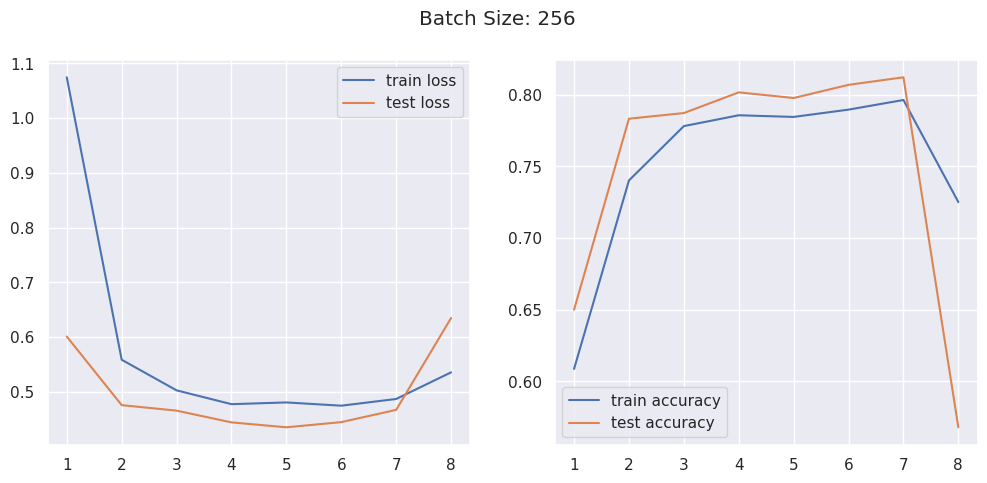

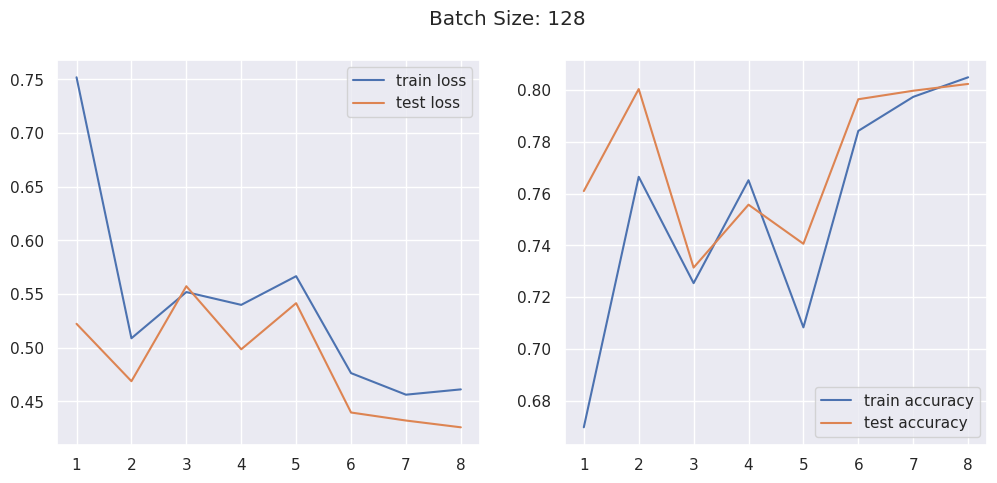

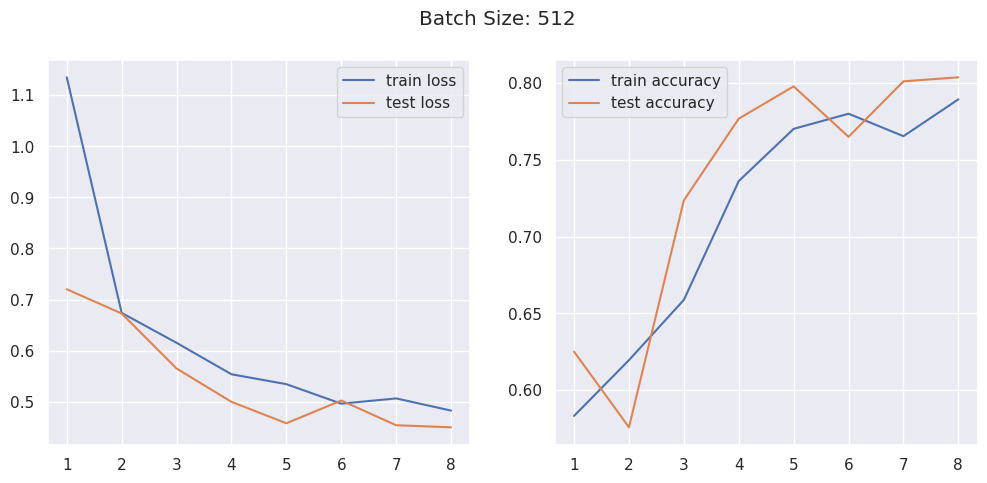

In [35]:
#fitting our training data to the model
print('Batch Count = 256')
mod11 = assign_model()
history1mod1 = mod11.fit(X_train, y_train, epochs=8, batch_size=256, 
                    validation_data=(X_test, y_test))
plot_metrics(history1mod1, 256)

print('Batch Count = 128')
mod21 = assign_model()
history2mod1 = mod21.fit(X_train, y_train, epochs=8, batch_size=128, 
                    validation_data=(X_test, y_test))
plot_metrics(history2mod1, 128)

print('Batch Count = 512')
mod31 = assign_model()
history3mod1 = mod31.fit(X_train, y_train, epochs=8, batch_size=512, 
                    validation_data=(X_test, y_test))
plot_metrics(history3mod1, 512)

Batch Count = 256
Epoch 1/8
24/24 [==============================] - 6s 131ms/step - loss: 0.9982 - accuracy: 0.6126 - val_loss: 0.6172 - val_accuracy: 0.6310
Epoch 2/8
24/24 [==============================] - 3s 109ms/step - loss: 0.5428 - accuracy: 0.7379 - val_loss: 0.4712 - val_accuracy: 0.7827
Epoch 3/8
24/24 [==============================] - 3s 110ms/step - loss: 0.4995 - accuracy: 0.7810 - val_loss: 0.4321 - val_accuracy: 0.8063
Epoch 4/8
24/24 [==============================] - 3s 106ms/step - loss: 0.4722 - accuracy: 0.7877 - val_loss: 0.4276 - val_accuracy: 0.8109
Epoch 5/8
24/24 [==============================] - 3s 108ms/step - loss: 0.4693 - accuracy: 0.7926 - val_loss: 0.4322 - val_accuracy: 0.8109
Epoch 6/8
24/24 [==============================] - 3s 107ms/step - loss: 0.4563 - accuracy: 0.7961 - val_loss: 0.4224 - val_accuracy: 0.8122
Epoch 7/8
24/24 [==============================] - 3s 110ms/step - loss: 0.4538 - accuracy: 0.8044 - val_loss: 0.4463 - val_accuracy: 0.

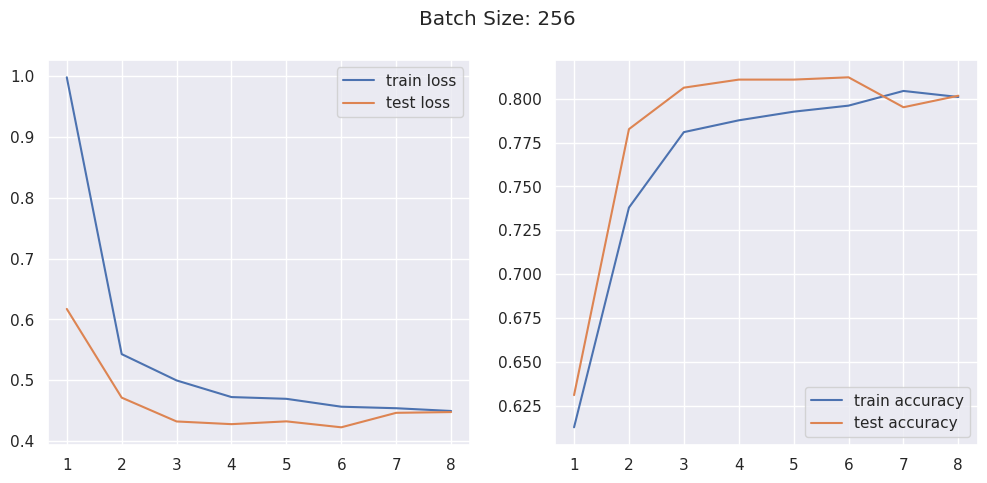

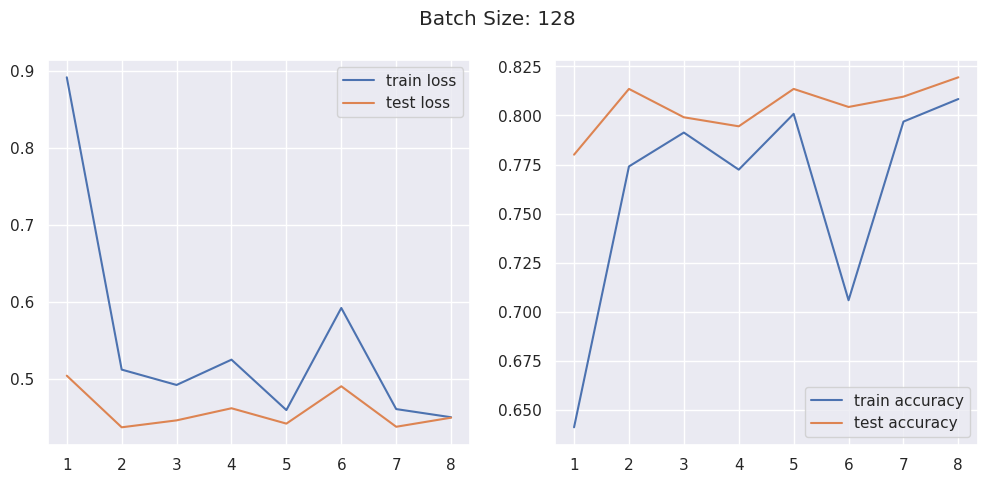

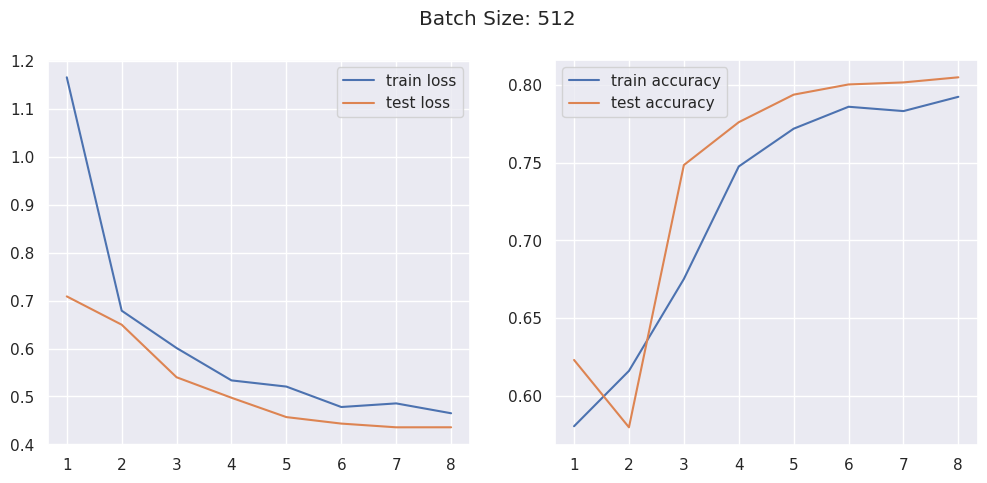

In [36]:
#fitting our training data to the model
print('Batch Count = 256')
mod12 = assign_model2()
history1mod2 = mod12.fit(X_train, y_train, epochs=8, batch_size=256, validation_data=(X_test, y_test))
plot_metrics(history1mod2, 256)

print('Batch Count = 128')
mod22 = assign_model2()
history2mod2 = mod22.fit(X_train, y_train, epochs=8, batch_size=128, validation_data=(X_test, y_test))
plot_metrics(history2mod2, 128)

print('Batch Count = 512')
mod32 = assign_model2()
history3mod2 = mod32.fit(X_train, y_train, epochs=8, batch_size=512, validation_data=(X_test, y_test))
plot_metrics(history3mod2, 512)

In [37]:
#Here we use our model to predict the test subset of the training data, print what the class vector looks like, and get a report on the metrics for the test data.
y_pred = mod22.predict(X_test)
y_classes = []
for i in y_pred:
    if i > 0.50:
        y_classes.append(1)
    else:
        y_classes.append(0)
print(y_classes)
print(classification_report(y_test, y_classes))

48/48 [==============================] - 1s 12ms/step
[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 

In [45]:
#Here we have our model predict on the actual test data. This gives us our submission classes. We have about a 77% score after submission.
print(test)
print(np.shape(test))
sub_pred = mod12.predict(test)
sub_classes = []
for i in sub_pred:
    if i > 0.50:
        sub_classes.append(1)
    else:
        sub_classes.append(0)
#print(y_classes)
#print(sub_classes)

[[ 777 1968   56 ...    0    0    0]
 [ 244  212  910 ...    0    0    0]
 [ 116    4  660 ...    0    0    0]
 ...
 [ 949  594  392 ...    0    0    0]
 [5020  499  437 ...    0    0    0]
 [5270 2405 1539 ...    0    0    0]]
(3263, 32)
102/102 [==============================] - 1s 10ms/step


In [46]:
#submitting our classifications
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['target'] = sub_classes
submission.set_index('id', inplace=True)
submission.to_csv('/kaggle/working/submission.csv')

## Conclusion
Here we saw that the addition of another dense layer will not necessarily increase the accuracy of a model, although we see slight increases in this notebook. The increase in trainable parameters can bring with it issues such as requiring a smaller learning rate or greater training time (epoch count). Batch size acts similarly, as a simple increase or decrease in batch size can cause issues like increasing fluctuations in loss of small batch models or increasing overfitting in large batch models. To counteract these things I should think about increasing epoch count until the fluctuations decrease in small batch models or including a dropout layer to decrease overfitting in large batch models. Interestingly enough, the first model shows a great reduction in accuracy during the final epoch. It would be very interesting to find out why this occurred. It may have reached overfitting but even then the training dataset accuracy drops off a cliff as well, and a larger batch model, which should overfit faster, does not have that large dip towards the end.

## References
https://www.kaggle.com/code/shivam017arora/disastrous-tweets-classification-w-deep-learning/notebook I learned a lot of techniques, including GloVe, from this notebook.
https://nlp.stanford.edu/projects/glove/ I used the pretrained embedding resource found here.